In [70]:
%matplotlib inline

links:
* http://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html
* https://software.intel.com/en-us/node/507042

In [93]:
# from minimg import load, MinImg, TYP_REAL32
from numba import jit, prange
import numba
import pylab as plt

from glob import glob
from math import radians, cos, sin, pi, atan2
import numpy as np

arr = np.ndarray((508, 262, 500), dtype=np.float32)


# for path in glob("d:\\tomography\\RS_8_4\\MMC1_2.82um_*.tif"):
for path in glob("/home/makov/diskmnt/big/yaivan/test_data/RS_8_4/MMC1_2.82um_*.tif"):
    idx = path[-8:-4]
    if not idx.isdigit():
        continue
    img = plt.imread(path).astype('float32')
    arr[int(idx, 10),:,:] = -np.log(img / np.max(img))
#     img = load(path).astype(TYP_REAL32)
#     arr[int(idx, 10),:,:] = -np.log(img / img.bounds()[1])


@jit(nopython=True)
def parker_weight(src):
    L = 225.082  # Camera to Source (mm)
    num_angles = src.shape[0]
    N = src.shape[1]
    step_rad = radians(0.400000)  # Rotation Step (deg)
    detector_px_sz = 22.597849 * 1e-3  # Image Pixel Size (mm)

    delta = atan2((N / 2 + 0.5) * detector_px_sz, L)

    for angle_idx in range(num_angles):
        beta = angle_idx * step_rad
        for detector_idx in range(N):
            alpha = atan2((N / 2 - detector_idx) * detector_px_sz, L)

            if 0 <= beta <= 2 * delta + 2 * alpha:
                weigth = sin((pi / 4) * (beta / (delta + alpha))) ** 2
            elif beta < pi + 2 * alpha:
                weigth = 1.0
            elif beta < pi + 2 * delta:
                weigth = sin((pi / 4) * (pi + 2 * delta - beta) / (delta - alpha)) ** 2
            else:
                weigth = 0.0
            src[angle_idx, detector_idx] *= weigth

@jit(nopython=True)
def pre_weight(src):
    L = 225.082  # Camera to Source (mm)
    num_angles = src.shape[0]
    N = src.shape[1]
    N2 = N / 2.0  # TODO: check it for odd N
    Nz = src.shape[2]
    Nz2 = Nz / 2  # TODO: check it for odd Nz
    
    detector_px_sz = 22.597849 * 1e-3  # Image Pixel Size (mm)

    for (y_idx, z_idx), _ in np.ndenumerate(src[0]):
        z = z_idx - Nz2
        y = N2 - y_idx

        dl2 = (z * z + y * y) * detector_px_sz**2
        k = L / np.sqrt(L * L + dl2)

        for angle_idx in range(num_angles):
            src[angle_idx, y_idx, z_idx] *=k
            
# @jit(nopython=True)
# def bp1d(src_filtered, out):
#     L = 225.082  # Camera to Source (mm)
#     l = 56.135  # Object to Source (mm)
#     detector_px_sz = 22.597849 * 1e-3  # Image Pixel Size (um)
#     object_px_sz = 22.597849 * 1e-3 / (L / l)
#     N = out.shape[-1]
#     N2 = N / 2.0
#     num_angles = src_filtered.shape[0]
#     step_rad = radians(0.400000)  # Rotation Step (deg)

#     for angle_idx in range(0, num_angles, 1):
#         # print("angle_idx %d" % (angle_idx,))
#         # print(angle_idx)
#         angle_rad = angle_idx * step_rad
#         cos_val = cos(angle_rad) * object_px_sz
#         sin_val = sin(angle_rad) * object_px_sz
#         projection_filtered = src_filtered[angle_idx]
#         for (y_idx, x_idx), _ in np.ndenumerate(out):
#             x = x_idx - N2
#             y = N2 - y_idx
#             t = x * cos_val - y * sin_val
#             s = x * sin_val + y * cos_val
#             a = t  # * object_px_sz
#             b = s  # * object_px_sz
#             d = (N * detector_px_sz) / 2.0 + b / (l + a) * L
#             d_idx = int(round(d / detector_px_sz))

#             if d_idx >= 0 and d_idx < N:
#                 out[y_idx, x_idx] += projection_filtered[d_idx]
#     out /= N * num_angles


# def fbp(src, out):
#     print("parker_weight")
#     parker_weight(src)
#     print("fft")
#     # FFT
#     N = out.shape[-1]
#     fft_filter=np.arange(N).astype(np.float32)
#     fft_filter = 1-np.abs(fft_filter-N//2)/(N//2)
#     fft_filter *= np.roll(np.hamming(N), N//2)
#     src_fft = np.fft.fft(src, axis=1)
#     src_fft *= fft_filter
#     src_filtered = np.real(np.fft.ifft(src_fft, axis=1))
#     print("bp")
#     bp1d(src_filtered, out)
#     print("bp finish")


@numba.jit(nopython=True)
def bp2d(src_filtered, out):
    L = 225.082  # Camera to Source (mm)
    l = 56.135  # Object to Source (mm)
    detector_px_sz = 22.597849 * 1e-3  # Image Pixel Size (um)
    object_px_sz = 22.597849 * 1e-3 / (L / l)
    N = out.shape[-1]
    N2 = N / 2.0  # TODO: check it for odd N
    Nz = out.shape[0]
    Nz2 = Nz / 2  # TODO: check it for odd Nz
    
    num_angles = src_filtered.shape[0]
    step_rad = radians(0.400000)  # Rotation Step (deg)

    for angle_idx in range(0, num_angles, 1):
        # print("angle_idx %d" % (angle_idx,))
#         print(angle_idx)
        angle_rad = angle_idx * step_rad
        cos_val = cos(angle_rad) * object_px_sz
        sin_val = sin(angle_rad) * object_px_sz
        # projection_filtered = src_filtered[angle_idx]
#         for (z_idx, y_idx, x_idx), _ in np.ndenumerate(out):

        for (y_idx, x_idx), _ in np.ndenumerate(out[0]):
            x = x_idx - N2
            y = N2 - y_idx

            t = x * cos_val - y * sin_val
            s = x * sin_val + y * cos_val
            a = t  # * object_px_sz
            b = s  # * object_px_sz
            dx = (N * detector_px_sz) / 2.0 + b / (l + a) * L
            dx_idx = int(round(dx / detector_px_sz))
            if not(dx_idx >= 0 and dx_idx < N):
                continue
            for z_idx in prange(out.shape[0]):
                z = z_idx - Nz2
                dz = (Nz * detector_px_sz) / 2.0 + z * object_px_sz / (l + a) * L
                dz_idx = int(round(dz / detector_px_sz))

                if dz_idx >= 0 and dz_idx < Nz:                    
                    out[z_idx, y_idx, x_idx] += src_filtered[angle_idx, dz_idx, dx_idx]

    out /= N * num_angles


def fdk(src):
    print("parker")
    print(src.shape)
    out = np.zeros((10, 500, 500), dtype=np.float32)
    for i in range(src.shape[1]):
        parker_weight(src[:,i,:])
    
    pre_weight(src)
    
    # FFT
    print("fft")
    N = out.shape[-1]
    fft_filter=np.arange(N).astype(np.float32)
    fft_filter = 1-np.abs(fft_filter-N//2)/(N//2)
    fft_filter *= np.roll(np.hamming(N), N//2)
    for i in range(src.shape[1]):
        src_fft = np.fft.fft(src[:,i,:], axis=1)
        src_fft *= fft_filter
        src[:,i,:] = np.real(np.fft.ifft(src_fft, axis=1))
    print("bp")
    # np.save('tmp', src)
    # src = np.load('tmp.npy')[:,-960//8-5:-960//8+5,:]
    bp2d(src[:,-960//8-5:-960//8+5,:], out)
    return out


out = fdk(arr)

# for z in range(out.shape[0]):
#     MinImg.fromarray(out[z]).save('out_%d.tif' % z)

parker
(508, 262, 500)
fft
bp


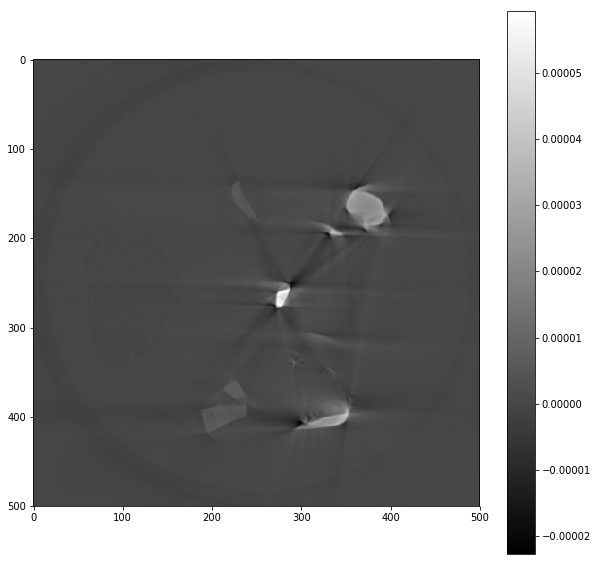

In [95]:
plt.figure(figsize=(10,10))
plt.imshow(out[5,:,:], cmap=plt.cm.gray)
plt.colorbar()
plt.show()


In [ ]:
# %load "/home/makov/diskmnt/big/yaivan/MMC_1/Raw/MMC1_2.82um_.log"
[System]
Scanner=Skyscan1172
Instrument S/N=08G01121
Hardware version=A
Software=Version 1. 5 (build 18)
Home directory=C:\SkyScan
Source Type=Hamamatsu 100/250
Camera=Hamamatsu 10Mp camera
Camera Pixel Size (um)=   11.32
CameraXYRatio=1.0023
Incl.in lifting (um/mm)=0.0000
[Acquisition]
Data directory=D:\Results\Yakimchuk\2015-Spectrum Reconctruction\MultiMineral Calibration\2015.03.18 MMC_1\Raw
Filename Prefix=MMC1_2.82um_
Number of Files= 2030
Source Voltage (kV)= 100
Source Current (uA)= 100
Number of Rows= 2096
Number of Columns= 4000
Image crop origin X=   0
Image crop origin Y=0
Camera binning=1x1
Image Rotation=0.6500
Gantry direction=CC
Image Pixel Size (um)=    2.82
Object to Source (mm)=56.135
Camera to Source (mm)=225.082
Vertical Object Position (mm)=6.900
Optical Axis (line)= 960
Filter=Al 0.5 mm
Image Format=TIFF
Depth (bits)=16
Screen LUT=0
Exposure (ms)=  1767
Rotation Step (deg)=0.100
Frame Averaging=ON (15)
Random Movement=OFF (10)
Use 360 Rotation=NO
Geometrical Correction=ON
Camera Offset=OFF
Median Filtering=ON
Flat Field Correction=ON
Rotation Direction=CC
Scanning Trajectory=ROUND
Type Of Motion=STEP AND SHOOT
Study Date and Time=Mar 19, 2015  10:11:11
Scan duration=16:08:02
[Reconstruction]
Reconstruction Program=NRecon
Program Version=Version: 1.6.5.8
Program Home Directory=C:\SkyScan\NRecon_GPU
Reconstruction engine=NReconServer
Engine version=Version: 1.6.5
Reconstruction from batch=No
Reconstruction servers= slb-7hlv74j  slb-9hlv74j  slb-7pbv74j 
Option for additional F4F float format=OFF
Dataset Origin=Skyscan1172
Dataset Prefix=MMC1_2.82um_
Dataset Directory=D:\Results\Yakimchuk\2015-Spectrum Reconctruction\MultiMineral Calibration\2015.03.18 MMC_1\Raw
Output Directory=D:\Results\Yakimchuk\2015-Spectrum Reconctruction\MultiMineral Calibration\2015.03.18 MMC_1\Reconstructed
Time and Date=Mar 19, 2015  13:00:46
First Section=96
Last Section=1981
Reconstruction duration per slice (seconds)=1.859491
Total reconstruction time (1886 slices) in seconds=3507.000000
Postalignment=-1.00
Section to Section Step=1
Sections Count=1886
Result File Type=PNG
Result File Header Length (bytes)=Unknown: compressed JPG format (100%)
Result Image Width (pixels)=4000
Result Image Height (pixels)=4000
Pixel Size (um)=2.82473
Reconstruction Angular Range (deg)=202.90
Use 180+=OFF
Angular Step (deg)=0.1000
Smoothing=0
Ring Artifact Correction=16
Draw Scales=OFF
Object Bigger than FOV=OFF
Reconstruction from ROI=OFF
Filter cutoff relative to Nyquisit frequency=100
Filter type=0
Filter type meaning(1)=0: Hamming (Ramp in case of optical scanner); 1: Hann; 2: Ramp; 3: Almost Ramp; 
Filter type meaning(2)=11: Cosine; 12: Shepp-Logan; [100,200]: Generalized Hamming, alpha=(iFilter-100)/100
Undersampling factor=1
Threshold for defect pixel mask (%)=0
Beam Hardening Correction (%)=92
CS Static Rotation (deg)=0.0
Minimum for CS to Image Conversion=-0.1800
Maximum for CS to Image Conversion=0.5200
HU Calibration=OFF
BMP LUT=0
Cone-beam Angle Horiz.(deg)=11.493867
Cone-beam Angle Vert.(deg)=6.037473
